<a href="https://colab.research.google.com/github/PremKumar-V/Advance_Projects/blob/main/LLM_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
!pip install language-tool-python --quiet

In [52]:
import re
import string
import random
import requests
import textwrap

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import language_tool_python
from nltk.corpus import words

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer, ngrams_iterator

In [53]:
tool = language_tool_python.LanguageTool('en-US')
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [2]:
cDATA_URL = 'https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/4.4%20-%20Lab%20-%20Word-Level%20RNN/fairy_tales_cleaned_most_common_5000_words.txt'
FILE_PATH = './data.txt'

def getData():
    response = requests.get(DATA_URL)
    with open(FILE_PATH, 'w') as file:
        file.write(response.text)

    with open(FILE_PATH, 'r') as file:
        text = file.read()

    return text

data = getData()

In [3]:
print(f"Length of Data: {len(data)}")

Length of Data: 2751174


In [4]:
print(f"Sample Data: '{data[:100]}'")

Sample Data: 'the happy prince. high above the city on a tall column stood the statue of the happy prince. he was '


In [5]:
sampleData = data[:95]
sampleData

'the happy prince. high above the city on a tall column stood the statue of the happy prince. he'

In [6]:
class Preprocessor():
    def __init__(self, data):
        self.data = data
        self.seq_length = 50
        self.chunk_size = self.seq_length + 1
        self.tokenizer = get_tokenizer('basic_english')

    def tokenize(self):
        return self.tokenizer(self.data)

    def buildVocab(self, tokens):

        def token_iterator():
            yield tokens

        vocab = build_vocab_from_iterator(token_iterator(), min_freq=1)
        return vocab

    def encodeTokens(self, tokens, vocab):
        encoding = torch.tensor([vocab[token] for token in tokens], dtype=torch.long)

        text_chunks = [encoding[i:i + self.chunk_size] for i in range(len(encoding) - self.chunk_size + 1)]

        for seq in text_chunks[:1]:
            input_seq = seq[:self.seq_length]
            target = seq[self.seq_length]

            input_seq_list = input_seq.tolist()
            target_list = target.tolist()

        return text_chunks

    def getData(self):
        tokens = self.tokenize()
        vocab = self.buildVocab(tokens)
        encodings = self.encodeTokens(tokens, vocab)

        return tokens, vocab, encodings

In [7]:
preprocessor = Preprocessor(data)
tokens, vocab, textChunks = preprocessor.getData()

print(f'Tokens: {tokens[:20]}')
print(f"Length of Tokens: {len(tokens)}")
print(f"Length of Vocabulary: {len(vocab)}")

Tokens: ['the', 'happy', 'prince', '.', 'high', 'above', 'the', 'city', 'on', 'a', 'tall', 'column', 'stood', 'the', 'statue', 'of', 'the', 'happy', 'prince', '.']
Length of Tokens: 584959
Length of Vocabulary: 5372


In [8]:
textChunks[:3]

[tensor([   1,  237,  106,    0,  436,  677,    1,  664,   27,    5, 1337, 4745,
          179,    1, 3888,    7,    1,  237,  106,    0,    4,    6,   49,  101,
         3493,  284,    0,   36,  138,   34,  338,  104,    1,  664,    5,   43,
         1856,    0,   38,   32,    1, 2399,   52,   20,   26,  338,   81,    0,
           35,   50,    4]),
 tensor([ 237,  106,    0,  436,  677,    1,  664,   27,    5, 1337, 4745,  179,
            1, 3888,    7,    1,  237,  106,    0,    4,    6,   49,  101, 3493,
          284,    0,   36,  138,   34,  338,  104,    1,  664,    5,   43, 1856,
            0,   38,   32,    1, 2399,   52,   20,   26,  338,   81,    0,   35,
           50,    4,   59]),
 tensor([ 106,    0,  436,  677,    1,  664,   27,    5, 1337, 4745,  179,    1,
         3888,    7,    1,  237,  106,    0,    4,    6,   49,  101, 3493,  284,
            0,   36,  138,   34,  338,  104,    1,  664,    5,   43, 1856,    0,
           38,   32,    1, 2399,   52,   20,   26, 

In [9]:
class TextDataset(Dataset):
    def __init__(self, text_chunks):
        self.text_chunks = text_chunks

    def __len__(self):
        return len(self.text_chunks)

    def __getitem__(self, idx):
        text_chunk = self.text_chunks[idx]
        return text_chunk[:-1].long(), text_chunk[1:].long()

dataset = TextDataset(textChunks)

In [10]:
for i in range(1):
    values = dataset[i]
    inputs, targets = values
    inputs_words = " ".join(vocab.lookup_tokens(inputs.tolist()))
    targets_words = " ".join(vocab.lookup_tokens(targets.tolist()))

    print(f"Input Tokens: {inputs}")
    print(f"Target Tokens: {targets}")
    print(f"Input Words: {inputs_words}")
    print(f"Target Words: {targets_words}")

Input Tokens: tensor([   1,  237,  106,    0,  436,  677,    1,  664,   27,    5, 1337, 4745,
         179,    1, 3888,    7,    1,  237,  106,    0,    4,    6,   49,  101,
        3493,  284,    0,   36,  138,   34,  338,  104,    1,  664,    5,   43,
        1856,    0,   38,   32,    1, 2399,   52,   20,   26,  338,   81,    0,
          35,   50])
Target Tokens: tensor([ 237,  106,    0,  436,  677,    1,  664,   27,    5, 1337, 4745,  179,
           1, 3888,    7,    1,  237,  106,    0,    4,    6,   49,  101, 3493,
         284,    0,   36,  138,   34,  338,  104,    1,  664,    5,   43, 1856,
           0,   38,   32,    1, 2399,   52,   20,   26,  338,   81,    0,   35,
          50,    4])
Input Words: the happy prince . high above the city on a tall column stood the statue of the happy prince . he was very much admired indeed . one night there flew over the city a little swallow . then when the autumn came they all flew away . what did
Target Words: happy prince . high abo

In [11]:
BATCH_SIZE = 64

dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

In [12]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [16]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn_hidden_size = rnn_hidden_size
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size,
                           batch_first=True)
        self.fc = nn.Linear(rnn_hidden_size, vocab_size)

    def forward(self, x, hidden, cell):
        out = self.embedding(x).unsqueeze(1)
        out, (hidden, cell) = self.rnn(out, (hidden, cell))
        out = self.fc(out).reshape(out.size(0), -1)
        return out, hidden, cell

    def init_hidden(self, batch_size):
        hidden = torch.zeros(1, batch_size, self.rnn_hidden_size)
        cell = torch.zeros(1, batch_size, self.rnn_hidden_size)
        return hidden.to(DEVICE), cell.to(DEVICE)

vocab_size = len(vocab)
embed_dim = 256
rnn_hidden_size = 512

model = RNN(vocab_size, embed_dim, rnn_hidden_size)
model = model.to(DEVICE)
model

RNN(
  (embedding): Embedding(5372, 256)
  (rnn): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=5372, bias=True)
)

In [20]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f'Parameter name: {name}, Shape: {param.shape}')

Parameter name: embedding.weight, Shape: torch.Size([5372, 256])
Parameter name: rnn.weight_ih_l0, Shape: torch.Size([2048, 256])
Parameter name: rnn.weight_hh_l0, Shape: torch.Size([2048, 512])
Parameter name: rnn.bias_ih_l0, Shape: torch.Size([2048])
Parameter name: rnn.bias_hh_l0, Shape: torch.Size([2048])
Parameter name: fc.weight, Shape: torch.Size([5372, 512])
Parameter name: fc.bias, Shape: torch.Size([5372])


In [31]:
def train(model, lr, epochs, device = DEVICE):
    accuracyArray = []
    lossArray = []
    seqLength = 50

    model.to(DEVICE)
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        hidden, cell = model.init_hidden(BATCH_SIZE)
        seq_batch, target_batch = next(iter(dataloader))
        seq_batch = seq_batch.to(device)
        target_batch = target_batch.to(device)
        optimizer.zero_grad()
        loss = 0
        correct_predictions = 0
        total_predictions = 0

        for w in range(seqLength):
            pred, hidden, cell = model(seq_batch[:, w], hidden, cell)
            loss += loss_fn(pred, target_batch[:, w])

            _, predicted_indices = torch.max(pred, 1)
            correct_predictions += torch.sum(predicted_indices == target_batch[:, w])
            total_predictions += target_batch[:, w].numel()

        accuracy = correct_predictions.item() / total_predictions
        accuracyArray.append(accuracy)
        loss.backward()
        optimizer.step()
        loss = loss.item() / seqLength
        lossArray.append(loss)

        if epoch % 500 == 0:
            print(f'Epoch {epoch} loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

    plt.plot(accuracyArray)
    plt.plot(lossArray)
    plt.legend(['Accuracy', 'Loss'])
    plt.title(f"{epochs} Epochs on {lr} Learning Rate")
    plt.show()

Epoch 0 loss: 6.3506, Accuracy: 0.0869


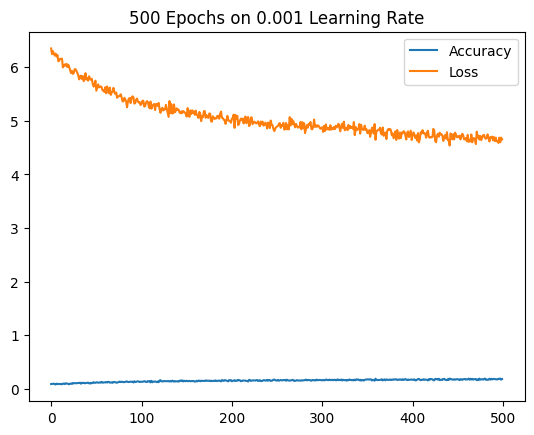

In [32]:
train(model, 0.001, 500)

In [34]:
def top_p_sampling(logits, temperature=1.0, top_p=0.9):
    scaled_logits = logits / temperature
    probabilities = torch.softmax(scaled_logits, dim=-1)
    sorted_indices = torch.argsort(probabilities, descending=True)
    sorted_probabilities = probabilities[sorted_indices]
    cumulative_probabilities = torch.cumsum(sorted_probabilities, dim=-1)
    indices_to_keep = cumulative_probabilities <= top_p
    truncated_probabilities = sorted_probabilities[indices_to_keep]
    truncated_probabilities /= torch.sum(truncated_probabilities)
    truncated_probabilities = truncated_probabilities.cpu().numpy()
    sorted_indices = sorted_indices.cpu().numpy()
    indices_to_keep = indices_to_keep.cpu().numpy()

    if not indices_to_keep.any():
        probabilities = torch.softmax(logits / temperature, dim=-1)
        next_word_index = torch.multinomial(probabilities, 1).item()
    else:
        next_word_index = np.random.choice(sorted_indices[indices_to_keep], p=truncated_probabilities)

    return torch.tensor(next_word_index).to(DEVICE)

In [61]:
def generate(model, seed_str,
           len_generated_text=100,
           temperature=1, top_p=0.95):
    model.to(DEVICE)
    tokenizer = get_tokenizer("basic_english")
    seed_tokens = tokenizer(seed_str)

    encoded_input = torch.tensor([vocab[t] for t in seed_tokens])
    encoded_input = torch.reshape(encoded_input, (1, -1)).to(DEVICE)

    generated_str = seed_str

    model.eval()
    with torch.inference_mode():
      hidden, cell = model.init_hidden(1)
      hidden = hidden.to(DEVICE)
      cell = cell.to(DEVICE)
      for w in range(len(seed_tokens)-1):
          _, hidden, cell = model(encoded_input[:, w].view(1), hidden, cell)

      last_word = encoded_input[:, -1]
      for i in range(len_generated_text):
          logits, hidden, cell = model(last_word.view(1), hidden, cell)
          logits = torch.squeeze(logits, 0)
          last_word = top_p_sampling(logits, temperature, top_p)
          generated_str += " " + str(vocab.lookup_token(last_word))


    text = generated_str.replace(' . ', '. ')


    grammar_errors = tool.check(text)
    english_vocab = set(words.words())
    text_words = re.findall(r'\b\w+\b', text.lower())
    vocabulary_errors = [word for word in text_words if word not in english_vocab]

    wrapped_output = textwrap.fill(text, width=80)
    print(f'Generated String of Length {len_generated_text} with {temperature} Temperature - \n{wrapped_output}')
    print()
    print("Grammar Errors:", *grammar_errors)
    print("Vocabulary Errors:", vocabulary_errors)


Epoch 0 loss: 4.6608, Accuracy: 0.1737
Epoch 500 loss: 4.3796, Accuracy: 0.1859
Epoch 1000 loss: 3.9847, Accuracy: 0.2328
Epoch 1500 loss: 3.8155, Accuracy: 0.2516
Epoch 2000 loss: 3.5119, Accuracy: 0.2897
Epoch 2500 loss: 3.4246, Accuracy: 0.2944
Epoch 3000 loss: 3.2306, Accuracy: 0.3203
Epoch 3500 loss: 3.0422, Accuracy: 0.3441
Epoch 4000 loss: 2.9058, Accuracy: 0.3778
Epoch 4500 loss: 2.7695, Accuracy: 0.4006


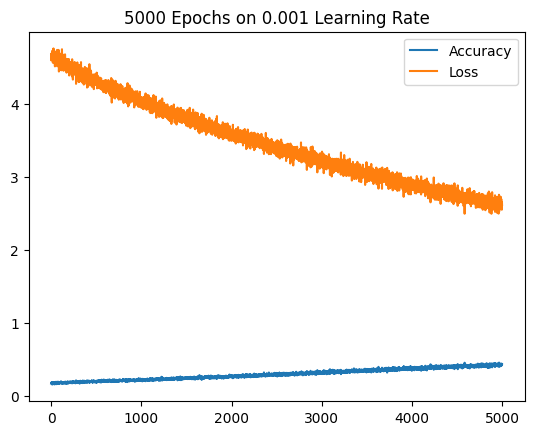

In [33]:
train(model, 0.001, 5000)

In [63]:
generate(model, seed_str='The king')

Generated String of Length 100 with 1 Temperature - 
The king. the children must be alone. they used to do it and they started down
the great stone until the house would have been trying to enjoy it. so the boy
went on it took out the knife in the middle of the forest. asked dorothy. they
asked her with the wizard for his own family. then after a while the two were
about the fruits and guardian of the north. the window the cat went to the boy
and asked him what was his best and upon them. the next day the

Grammar Errors: Offset 10, length 3, Rule ID: UPPERCASE_SENTENCE_START
Message: This sentence does not start with an uppercase letter.
Suggestion: The
The king. the children must be alone. they used to do...
          ^^^ Offset 38, length 4, Rule ID: UPPERCASE_SENTENCE_START
Message: This sentence does not start with an uppercase letter.
Suggestion: They
The king. the children must be alone. they used to do it and they started down the...
                                      ^^^^ O

In [62]:
generate(model, seed_str='The king', temperature = 0.5)

Generated String of Length 100 with 0.5 Temperature - 
The king and queen had sent for her to the king. they were the most beautiful
maiden all of the family that they had left them. now the king had to be taken
from the field all the beasts of the lad who was so beautiful that he could not
get away from the golden fleece. when he reached them he discovered that the
time was so great that he was a king. he was a king and queen and his mother had
a hard life of the country to be married. after this the brahmin expressed

Grammar Errors: Offset 49, length 4, Rule ID: UPPERCASE_SENTENCE_START
Message: This sentence does not start with an uppercase letter.
Suggestion: They
...and queen had sent for her to the king. they were the most beautiful maiden all of t...
                                           ^^^^ Offset 85, length 10, Rule ID: ALL_OF_THE
Message: Consider using “all the”.
Suggestion: all the
...ng. they were the most beautiful maiden all of the family that they had left them. 

Epoch 0 loss: 2.7800, Accuracy: 0.3941
Epoch 500 loss: 3.3498, Accuracy: 0.2969
Epoch 1000 loss: 3.2255, Accuracy: 0.3200
Epoch 1500 loss: 3.2077, Accuracy: 0.3041
Epoch 2000 loss: 3.0357, Accuracy: 0.3216
Epoch 2500 loss: 3.0699, Accuracy: 0.3266
Epoch 3000 loss: 3.0706, Accuracy: 0.3178
Epoch 3500 loss: 3.2134, Accuracy: 0.3013
Epoch 4000 loss: 3.3437, Accuracy: 0.2787
Epoch 4500 loss: 3.2385, Accuracy: 0.2909
Epoch 5000 loss: 3.1987, Accuracy: 0.2972
Epoch 5500 loss: 3.2862, Accuracy: 0.2884
Epoch 6000 loss: 3.2766, Accuracy: 0.3031
Epoch 6500 loss: 3.3679, Accuracy: 0.2719
Epoch 7000 loss: 3.2458, Accuracy: 0.2881
Epoch 7500 loss: 3.4572, Accuracy: 0.2709
Epoch 8000 loss: 3.3446, Accuracy: 0.2819
Epoch 8500 loss: 3.3369, Accuracy: 0.2706
Epoch 9000 loss: 3.4429, Accuracy: 0.2712
Epoch 9500 loss: 3.2437, Accuracy: 0.2859


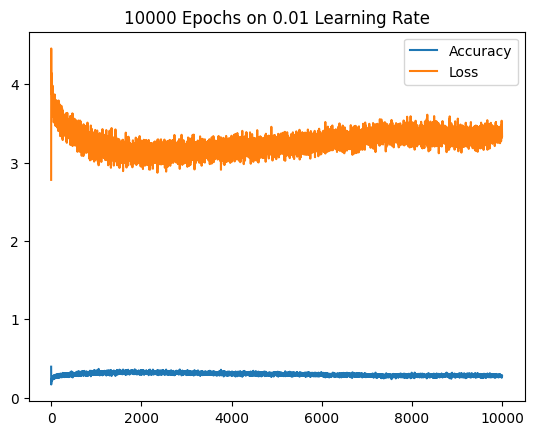

In [64]:
train(model, 0.01, 10000)

In [65]:
generate(model, seed_str='The king')

Generated String of Length 100 with 1 Temperature - 
The king found he searched every day even the mouse again to see if but they
didnt know what a guy could be had. one hundred these hid the wall frozen to at
a moment and lo t run away. the birds had been so late that it were little past
the kings daughter followed through the house. she ran up to ring as if she
could make him wedding and every day and to it the rajah brought him a large and
to lay down to sleep. soon following everybody they went into the garden. when

Grammar Errors: Offset 65, length 6, Rule ID: AND_BUT
Message: Please check if you only wanted to use one conjunction here.
Suggestion: if; but
...d every day even the mouse again to see if but they didnt know what a guy could be had...
                                           ^^^^^^ Offset 77, length 5, Rule ID: EN_CONTRACTION_SPELLING
Message: Possible spelling mistake found.
Suggestion: didn't
...even the mouse again to see if but they didnt know what a guy could 